In [2]:
%run setup.py

In [3]:
stars = pd.read_excel(rootpath+'sample/samples.xlsx')
idx = ((stars['ifmodelling']==1))
#         & (kepler['numax']>0) & 
#        (kepler['m_h']>-0.4) & (kepler['m_h']<0.4) &
#        (kepler['ALPHA_M']<0.05) & (kepler['ALPHA_M']>-0.05)) | np.isin(kepler['names'],['Sun','mu Her']) # & np.isfinite(kepler['DPi1_V16'])

stars = stars.loc[idx,:].reset_index(drop=True)

modes = pd.read_excel(rootpath+'sample/modes.xlsx')

In [4]:
## pick global parameters from bayesian modelling

def retrieve_data_to_table(table, filepath, tcols, dcols):
    Ncol = len(tcols)
    for istar, star in table.iterrows():
        for icol in range(Ncol):
            file = filepath.format(star['KIC'])
            if not os.path.exists(file): continue
            data=ascii.read(file, delimiter=',')
            table.loc[istar, tcols[icol]] = data[dcols[icol]][1]
            table.loc[istar, 'e_'+tcols[icol]] = (data[dcols[icol]][2]-data[dcols[icol]][0])/2.
    return table

data_cols = ['star_mass', 'numax_scaling', 'radius', 'delta_nu_scaling', 'Teff', 'amlt', 'surf_corr_at_numax', 'Dnu_freq',]
table_cols = ['mass', 'numax', 'radius', 'Dnu', 'Teff', 'amlt', 'surf_corr', 'Dnu_freq', ]

data_col_names = data_cols
table_col_names = [t+'_micp' for t in table_cols]
filepath = rootpath+'hpc/results_sc_combined_linear_ind/{:0.0f}/summary_prob.txt'
stars = retrieve_data_to_table(stars, filepath, table_col_names, data_col_names)

In [5]:
# cat ../hpc/results_sc_combined_linear_ind/0/summary_prob.txt

for istar, star in stars.loc[:,:].iterrows():
    filepath = '../hpc/results_sc_combined_linear_ind/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): continue
    data = h5py.File(filepath, 'r')
    
    cols = ['chi2', 'eps']
    
    chi2, eps = [data[col][:] for col in cols]
    prob = np.exp(-chi2/2.)
    
    res = se.quantile(eps.reshape(-1,1), [0.16, 0.50, 0.84], weights=prob)
    stars.loc[istar,'eps_micp'] = res[1,0]
    stars.loc[istar,'e_eps_micp'] = (res[2,0]-res[0,0])/2.

In [6]:
idx = np.isin(stars['stage'], ['ms', 'esg', 'lsg', 'rgb']) #& (stars['numax']>900)
sample = stars.loc[idx,:].reset_index(drop=True)

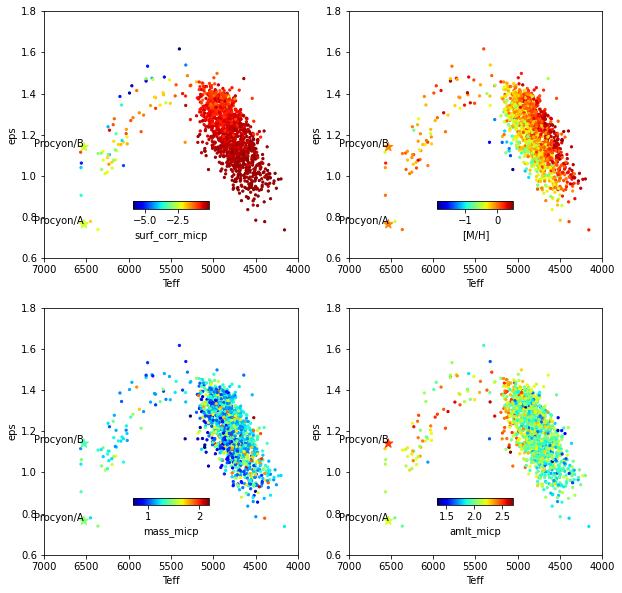

In [7]:
fig, axes = plt.subplots(figsize=[10,10], nrows=2, ncols=2, squeeze=False)
axes = axes.reshape(-1)

import matplotlib.colors

zvals = ['surf_corr_micp', '[M/H]', 'mass_micp', 'amlt_micp']
for iax in range(len(axes)):
    zval = zvals[iax]
    norm = matplotlib.colors.Normalize(vmin=sample[zval].min(), vmax=sample[zval].max())
    pro = np.isin(sample['names'], ['Procyon/A', 'Procyon/B'])
    idx = (~pro) #& (sample['Teff']>6000)
    
    c=axes[iax].scatter(sample.loc[idx,'Teff'], sample.loc[idx,'eps_micp'], c=sample.loc[idx,zval], s=5, cmap='jet', norm=norm)
    axes[iax].scatter(sample.loc[pro,'Teff'], sample.loc[pro,'eps_micp'], c=sample.loc[pro,zval], marker='*', s=90, cmap='jet', norm=norm)
    axes[iax].set_xlim(7000, 4000)
    axes[iax].set_ylim(0.6, 1.8)
    axes[iax].set_xlabel('Teff')
    axes[iax].set_ylabel('eps')
    
    cax = axes[iax].inset_axes([0.35, 0.2, 0.3, 0.03], transform=axes[iax].transAxes)
    fig.colorbar(c, cax=cax, orientation='horizontal').set_label(zval)

    for istar, star in sample.loc[pro,:].iterrows():
        axes[iax].text(sample.loc[istar,'Teff'], sample.loc[istar,'eps_micp'], sample.loc[istar,'names'], ha='right')

In [81]:
idx = np.isin(sample['names'], ['Procyon/A', 'Procyon/B'])
sample.loc[idx, ['KIC', 'names', 'eps_micp', 'mass_micp', 'e_mass_micp', 'radius_micp', 'e_radius_micp']]
# mass 1.49 +/ 0.01
# radius 2.03 +/- 0.01

KIC      names  eps_micp  mass_micp  e_mass_micp  radius_micp  \
51    2  Procyon/A  0.765512    1.46274     0.054885     2.019068   
52    3  Procyon/B  1.140583    1.35493     0.134470     1.968155   

    e_radius_micp  
51       0.029164  
52       0.059904

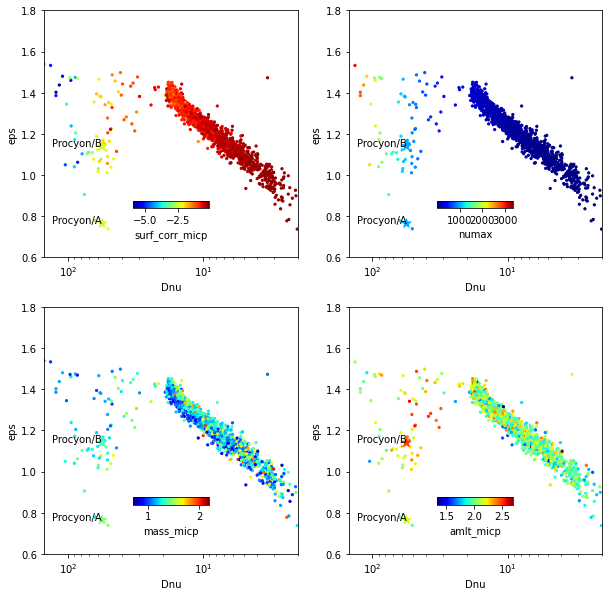

In [8]:
fig, axes = plt.subplots(figsize=[10,10], nrows=2, ncols=2, squeeze=False)
axes = axes.reshape(-1)

import matplotlib.colors

zvals = ['surf_corr_micp', 'numax', 'mass_micp', 'amlt_micp']
for iax in range(len(axes)):
    zval = zvals[iax]
    norm = matplotlib.colors.Normalize(vmin=sample[zval].min(), vmax=sample[zval].max())
    pro = np.isin(sample['names'], ['Procyon/A', 'Procyon/B'])
    idx = (~pro) #& (sample['Teff']>6000)
    
    c=axes[iax].scatter(sample.loc[idx,'Dnu'], sample.loc[idx,'eps_micp'], c=sample.loc[idx,zval], s=5, cmap='jet', norm=norm)
    axes[iax].scatter(sample.loc[pro,'Dnu'], sample.loc[pro,'eps_micp'], c=sample.loc[pro,zval], marker='*', s=90, cmap='jet', norm=norm)
    axes[iax].set_xlim(150., 2.)
    axes[iax].set_xscale('log')
    axes[iax].set_ylim(0.6, 1.8)
    axes[iax].set_xlabel('Dnu')
    axes[iax].set_ylabel('eps')
    
    cax = axes[iax].inset_axes([0.35, 0.2, 0.3, 0.03], transform=axes[iax].transAxes)
    fig.colorbar(c, cax=cax, orientation='horizontal').set_label(zval)

    for istar, star in sample.loc[pro,:].iterrows():
        axes[iax].text(sample.loc[istar,'Dnu'], sample.loc[istar,'eps_micp'], sample.loc[istar,'names'], ha='right')

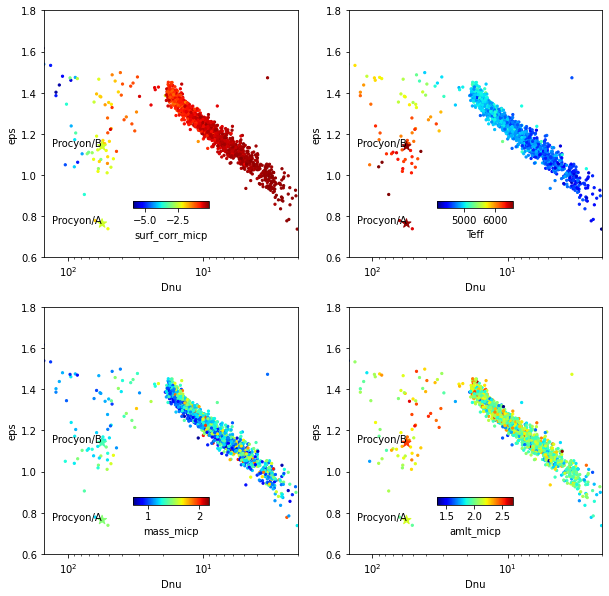

In [10]:
fig, axes = plt.subplots(figsize=[10,10], nrows=2, ncols=2, squeeze=False)
axes = axes.reshape(-1)

import matplotlib.colors

zvals = ['surf_corr_micp', 'Teff', 'mass_micp', 'amlt_micp']
for iax in range(len(axes)):
    zval = zvals[iax]
    norm = matplotlib.colors.Normalize(vmin=sample[zval].min(), vmax=sample[zval].max())
    pro = np.isin(sample['names'], ['Procyon/A', 'Procyon/B'])
    idx = (~pro) #& (sample['Teff']>6000)
    
    c=axes[iax].scatter(sample.loc[idx,'Dnu'], sample.loc[idx,'eps_micp'], c=sample.loc[idx,zval], s=5, cmap='jet', norm=norm)
    axes[iax].scatter(sample.loc[pro,'Dnu'], sample.loc[pro,'eps_micp'], c=sample.loc[pro,zval], marker='*', s=90, cmap='jet', norm=norm)
    axes[iax].set_xlim(150., 2.)
    axes[iax].set_xscale('log')
    axes[iax].set_ylim(0.6, 1.8)
    axes[iax].set_xlabel('Dnu')
    axes[iax].set_ylabel('eps')
    
    cax = axes[iax].inset_axes([0.35, 0.2, 0.3, 0.03], transform=axes[iax].transAxes)
    fig.colorbar(c, cax=cax, orientation='horizontal').set_label(zval)

    for istar, star in sample.loc[pro,:].iterrows():
        axes[iax].text(sample.loc[istar,'Dnu'], sample.loc[istar,'eps_micp'], sample.loc[istar,'names'], ha='right')

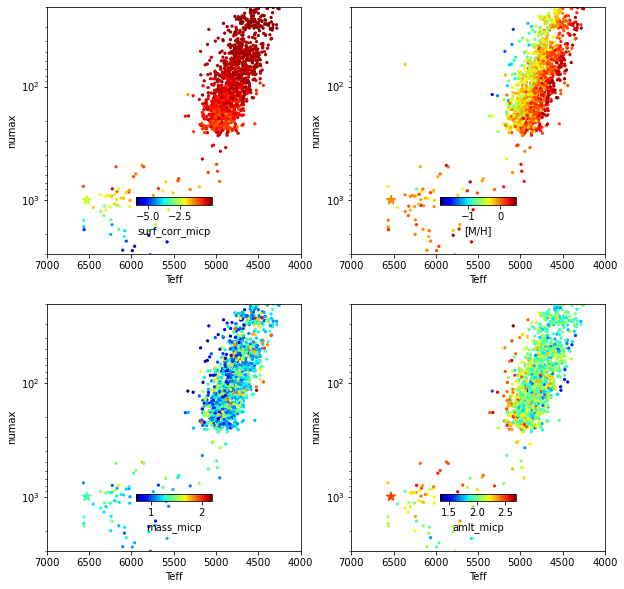

In [140]:
fig, axes = plt.subplots(figsize=[10,10], nrows=2, ncols=2, squeeze=False)
axes = axes.reshape(-1)

import matplotlib.colors

zvals = ['surf_corr_micp', '[M/H]', 'mass_micp', 'amlt_micp']
for iax in range(len(axes)):
    zval = zvals[iax]
    norm = matplotlib.colors.Normalize(vmin=sample[zval].min(), vmax=sample[zval].max())
    pro = np.isin(sample['names'], ['Procyon/A', 'Procyon/B'])
    idx = (~pro) #& (sample['Teff']>6000)
    
    c=axes[iax].scatter(sample.loc[idx,'Teff'], sample.loc[idx,'numax'], c=sample.loc[idx,zval], s=5, cmap='jet', norm=norm)
    axes[iax].scatter(sample.loc[pro,'Teff'], sample.loc[pro,'numax'], c=sample.loc[pro,zval], marker='*', s=90, cmap='jet', norm=norm)
    axes[iax].set_xlim(7000, 4000)
    axes[iax].set_yscale('log')
    axes[iax].set_ylim(3000,20)
    axes[iax].set_xlabel('Teff')
    axes[iax].set_ylabel('numax')
    
    cax = axes[iax].inset_axes([0.35, 0.2, 0.3, 0.03], transform=axes[iax].transAxes)
    fig.colorbar(c, cax=cax, orientation='horizontal').set_label(zval)

#     for istar, star in sample.loc[pro,:].iterrows():
#         axes[iax].text(sample.loc[istar,'Teff'], sample.loc[istar,'eps_micp'], sample.loc[istar,'names'], ha='right')

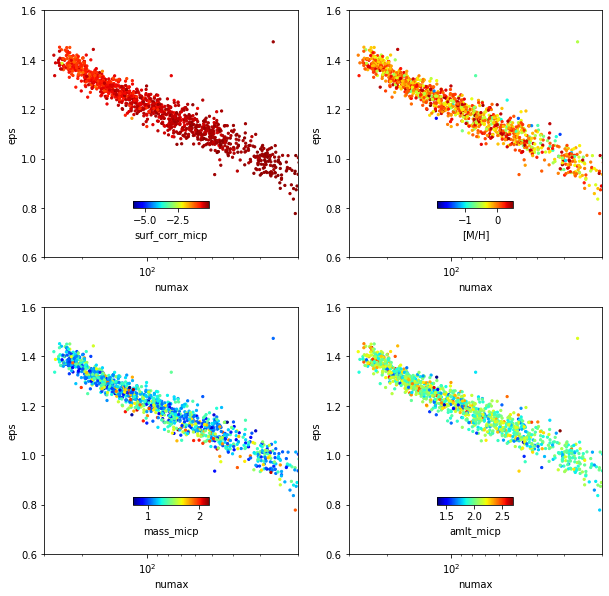

In [146]:
fig, axes = plt.subplots(figsize=[10,10], nrows=2, ncols=2, squeeze=False)
axes = axes.reshape(-1)

import matplotlib.colors

zvals = ['surf_corr_micp', '[M/H]', 'mass_micp', 'amlt_micp']
for iax in range(len(axes)):
    zval = zvals[iax]
    norm = matplotlib.colors.Normalize(vmin=sample[zval].min(), vmax=sample[zval].max())
    pro = np.isin(sample['names'], ['Procyon/A', 'Procyon/B'])
    idx = (~pro) #& (sample['Teff']>6000)
    
    c=axes[iax].scatter(sample.loc[idx,'numax'], sample.loc[idx,'eps_micp'], c=sample.loc[idx,zval], s=5, cmap='jet', norm=norm)
    axes[iax].scatter(sample.loc[pro,'numax'], sample.loc[pro,'eps_micp'], c=sample.loc[pro,zval], marker='*', s=90, cmap='jet', norm=norm)
    axes[iax].set_ylim(0.6, 1.6)
    axes[iax].set_xscale('log')
    axes[iax].set_xlim(300,20)
    axes[iax].set_xlabel('numax')
    axes[iax].set_ylabel('eps')
    
    cax = axes[iax].inset_axes([0.35, 0.2, 0.3, 0.03], transform=axes[iax].transAxes)
    fig.colorbar(c, cax=cax, orientation='horizontal').set_label(zval)

#     for istar, star in sample.loc[pro,:].iterrows():
#         axes[iax].text(sample.loc[istar,'Teff'], sample.loc[istar,'eps_micp'], sample.loc[istar,'names'], ha='right')

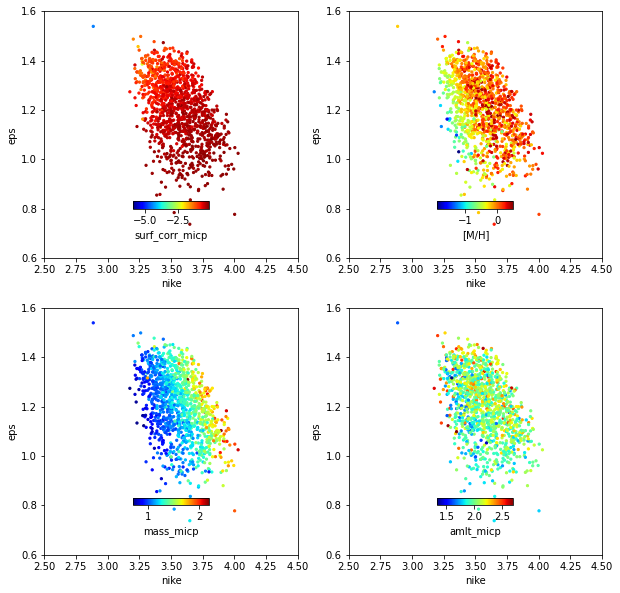

In [149]:
fig, axes = plt.subplots(figsize=[10,10], nrows=2, ncols=2, squeeze=False)
axes = axes.reshape(-1)

import matplotlib.colors

zvals = ['surf_corr_micp', '[M/H]', 'mass_micp', 'amlt_micp']
for iax in range(len(axes)):
    zval = zvals[iax]
    norm = matplotlib.colors.Normalize(vmin=sample[zval].min(), vmax=sample[zval].max())
    pro = np.isin(sample['names'], ['Procyon/A', 'Procyon/B'])
    idx = (~pro) & (sample['Teff']<5500)
    
    c=axes[iax].scatter(sample.loc[idx,'numax']**0.75/sample.loc[idx,'Dnu'], sample.loc[idx,'eps_micp'], c=sample.loc[idx,zval], s=5, cmap='jet', norm=norm)
#     axes[iax].scatter(sample.loc[pro,'numax']**0.75/sample.loc[idx,'Delnu'], sample.loc[pro,'eps_micp'], c=sample.loc[pro,zval], marker='*', s=90, cmap='jet', norm=norm)
    axes[iax].set_ylim(0.6, 1.6)
#     axes[iax].set_xscale('log')
    axes[iax].set_xlim(2.5, 4.5)
    axes[iax].set_xlabel('nike')
    axes[iax].set_ylabel('eps')
    
    cax = axes[iax].inset_axes([0.35, 0.2, 0.3, 0.03], transform=axes[iax].transAxes)
    fig.colorbar(c, cax=cax, orientation='horizontal').set_label(zval)

#     for istar, star in sample.loc[pro,:].iterrows():
#         axes[iax].text(sample.loc[istar,'Teff'], sample.loc[istar,'eps_micp'], sample.loc[istar,'names'], ha='right')

In [101]:
mass, e_mass = 1.49, 0.01
radius, e_radius = 2.03, 0.01
density_obs = 1.49**0.5 * 2.03**-1.5 
e_density_obs = density_obs * (0.5*(e_mass/mass)**2.0 + 1.5*(e_radius/radius)**2.0)**0.5

cols = ['star_mass', 'radius', 'Teff', 'eps', 'log_g', 'luminosity', 'numax_scaling']
labels=['mass', 'radius', 'Teff', 'eps', 'log_g', 'L', 'numax', 'density']
truths=[1.49, 2.03, None, None, None, None, None, density_obs,]

In [103]:
import warnings
warnings.filterwarnings("ignore")

In [120]:
data = h5py.File('../hpc/results_sc_combined_linear_ind/{:0.0f}/data.h5'.format(2), 'r')
df1 = pd.DataFrame(np.array([data[col][:] for col in cols]).T, columns=cols)
df1['density']=df1['star_mass']**0.5 * df1['radius']**-1.5
prob1 = np.exp(-data['chi2'][:]/2.)
idx = prob1>0.000001
df1, prob1 = df1[idx], prob1[idx]

data = h5py.File('../hpc/results_sc_combined_linear_ind/{:0.0f}/data.h5'.format(3), 'r')
df2 = pd.DataFrame(np.array([data[col][:] for col in cols]).T, columns=cols)
df2['density']=df2['star_mass']**0.5 * df2['radius']**-1.5
prob2 = np.exp(-data['chi2'][:]/2.)
idx = (prob2>0.000001) & (df2['eps']>0.9)
df2, prob2 = df2[idx], prob2[idx]

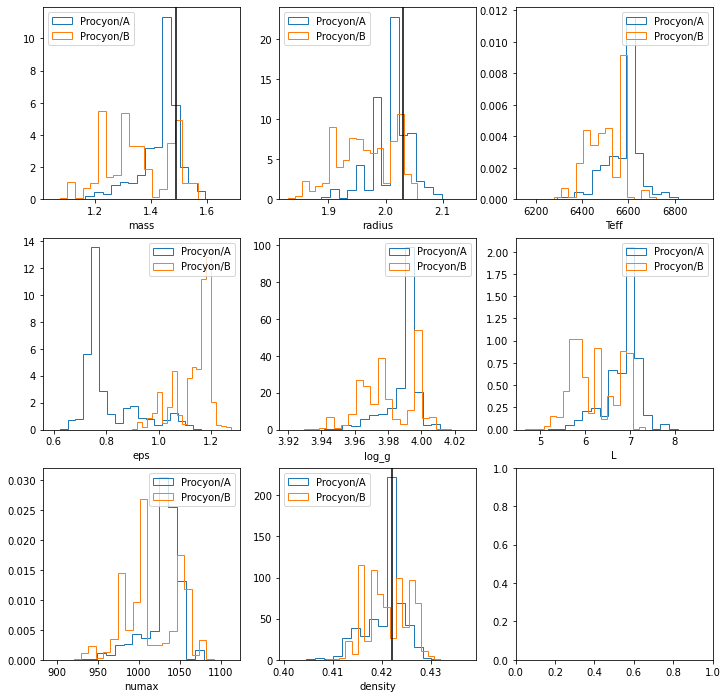

In [124]:
fig, axes = plt.subplots(figsize=[12,12], nrows=3, ncols=3, squeeze=False)
axes = axes.reshape(-1)

for iax in range(len(labels)):
    var = df1.columns[iax]
    axes[iax].hist(df1[var], weights=prob1, bins=20, histtype='step', label='Procyon/A', density=True)
    axes[iax].hist(df2[var], weights=prob2, bins=20, histtype='step', label='Procyon/B', density=True)
    if not (truths[iax] is None):
         axes[iax].axvline(truths[iax], color='k')
    axes[iax].set_xlabel(labels[iax])
    axes[iax].legend()

In [61]:
ls ../hpc/results_sc_combined_linear_ind/2

corner_prob_classical.png       summary_best.txt
corner_prob.png                 summary_prob_classical.txt
corner_prob_seismic.png         summary_prob_seismic.txt
data.h5                         summary_prob.txt
echelle_top10_prob_seismic.png


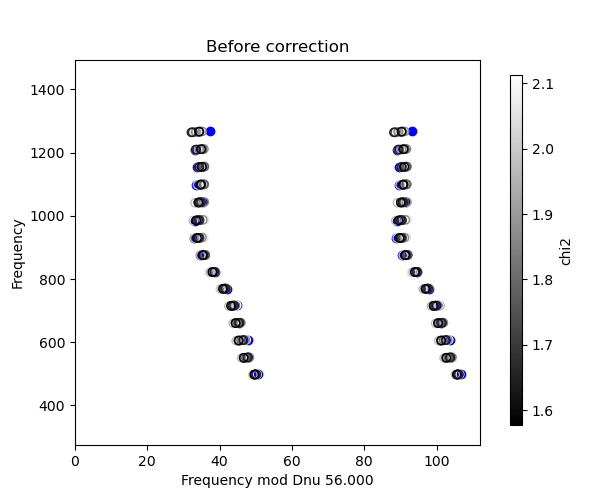

In [62]:
from IPython.display import Image
Image(filename='../hpc/results_sc_combined_linear_ind/{:0.0f}/echelle_top10_prob_seismic.png'.format(2)) 

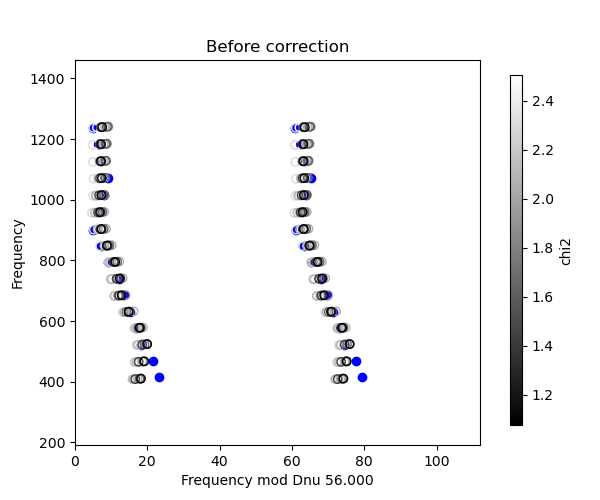

In [63]:
from IPython.display import Image
Image(filename='../hpc/results_sc_combined_linear_ind/{:0.0f}/echelle_top10_prob_seismic.png'.format(3)) 

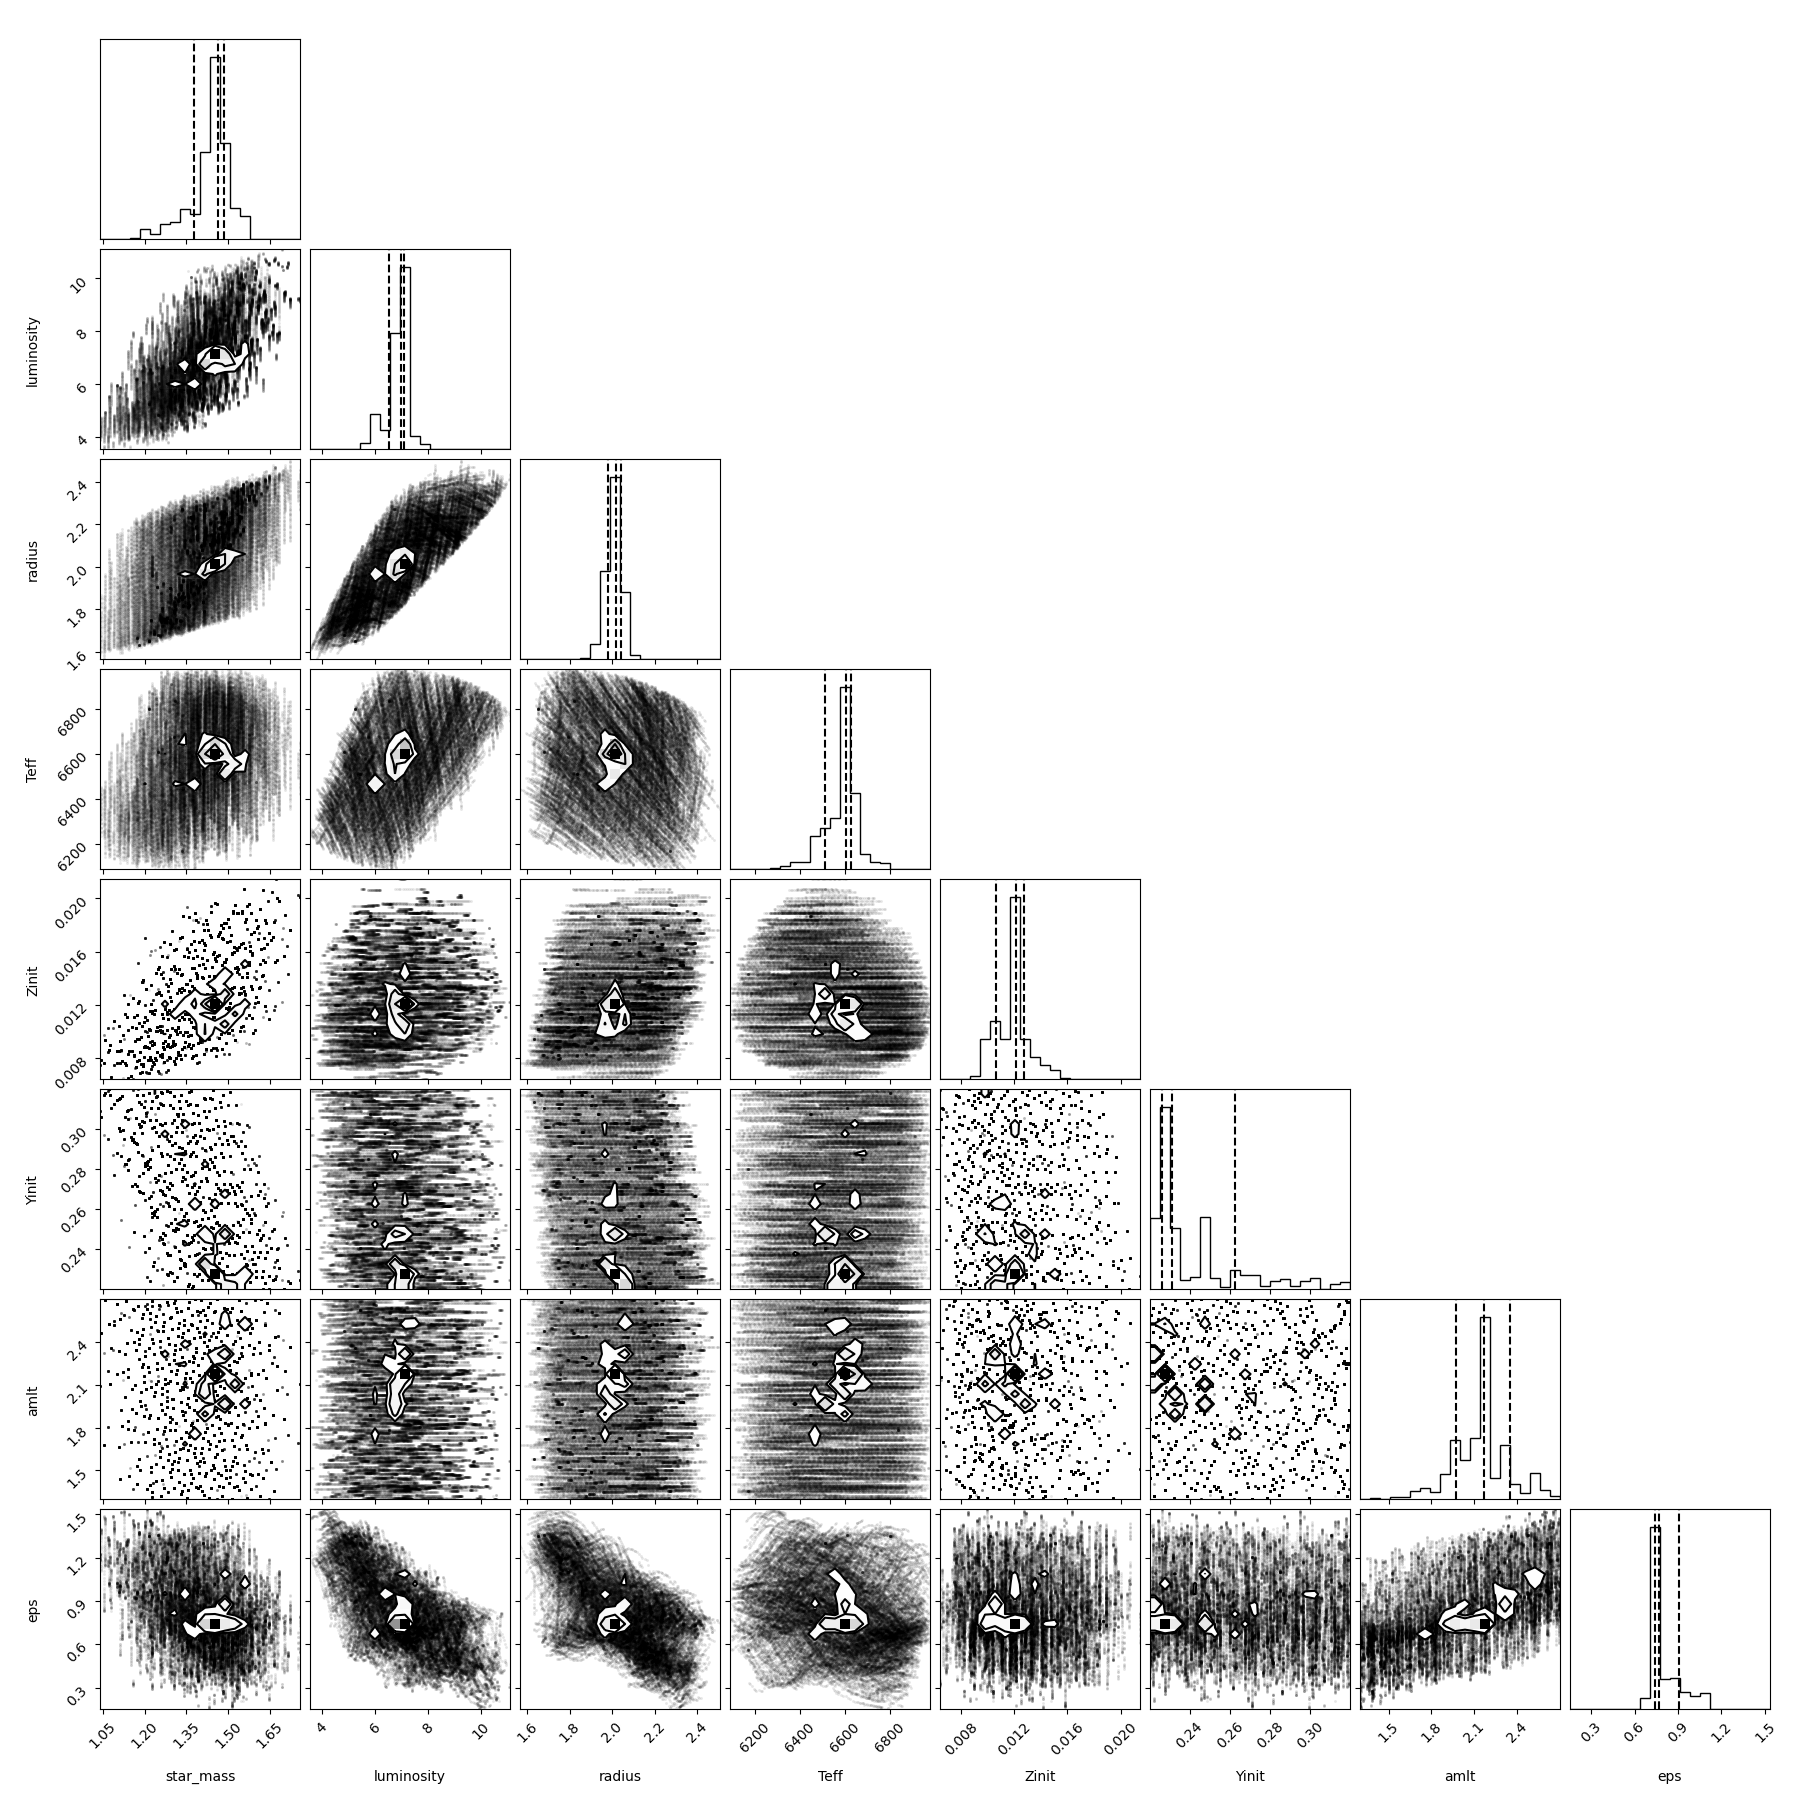

In [78]:
from IPython.display import Image
Image(filename='../hpc/results_sc_combined_linear_ind/{:0.0f}/corner_prob.png'.format(2)) 

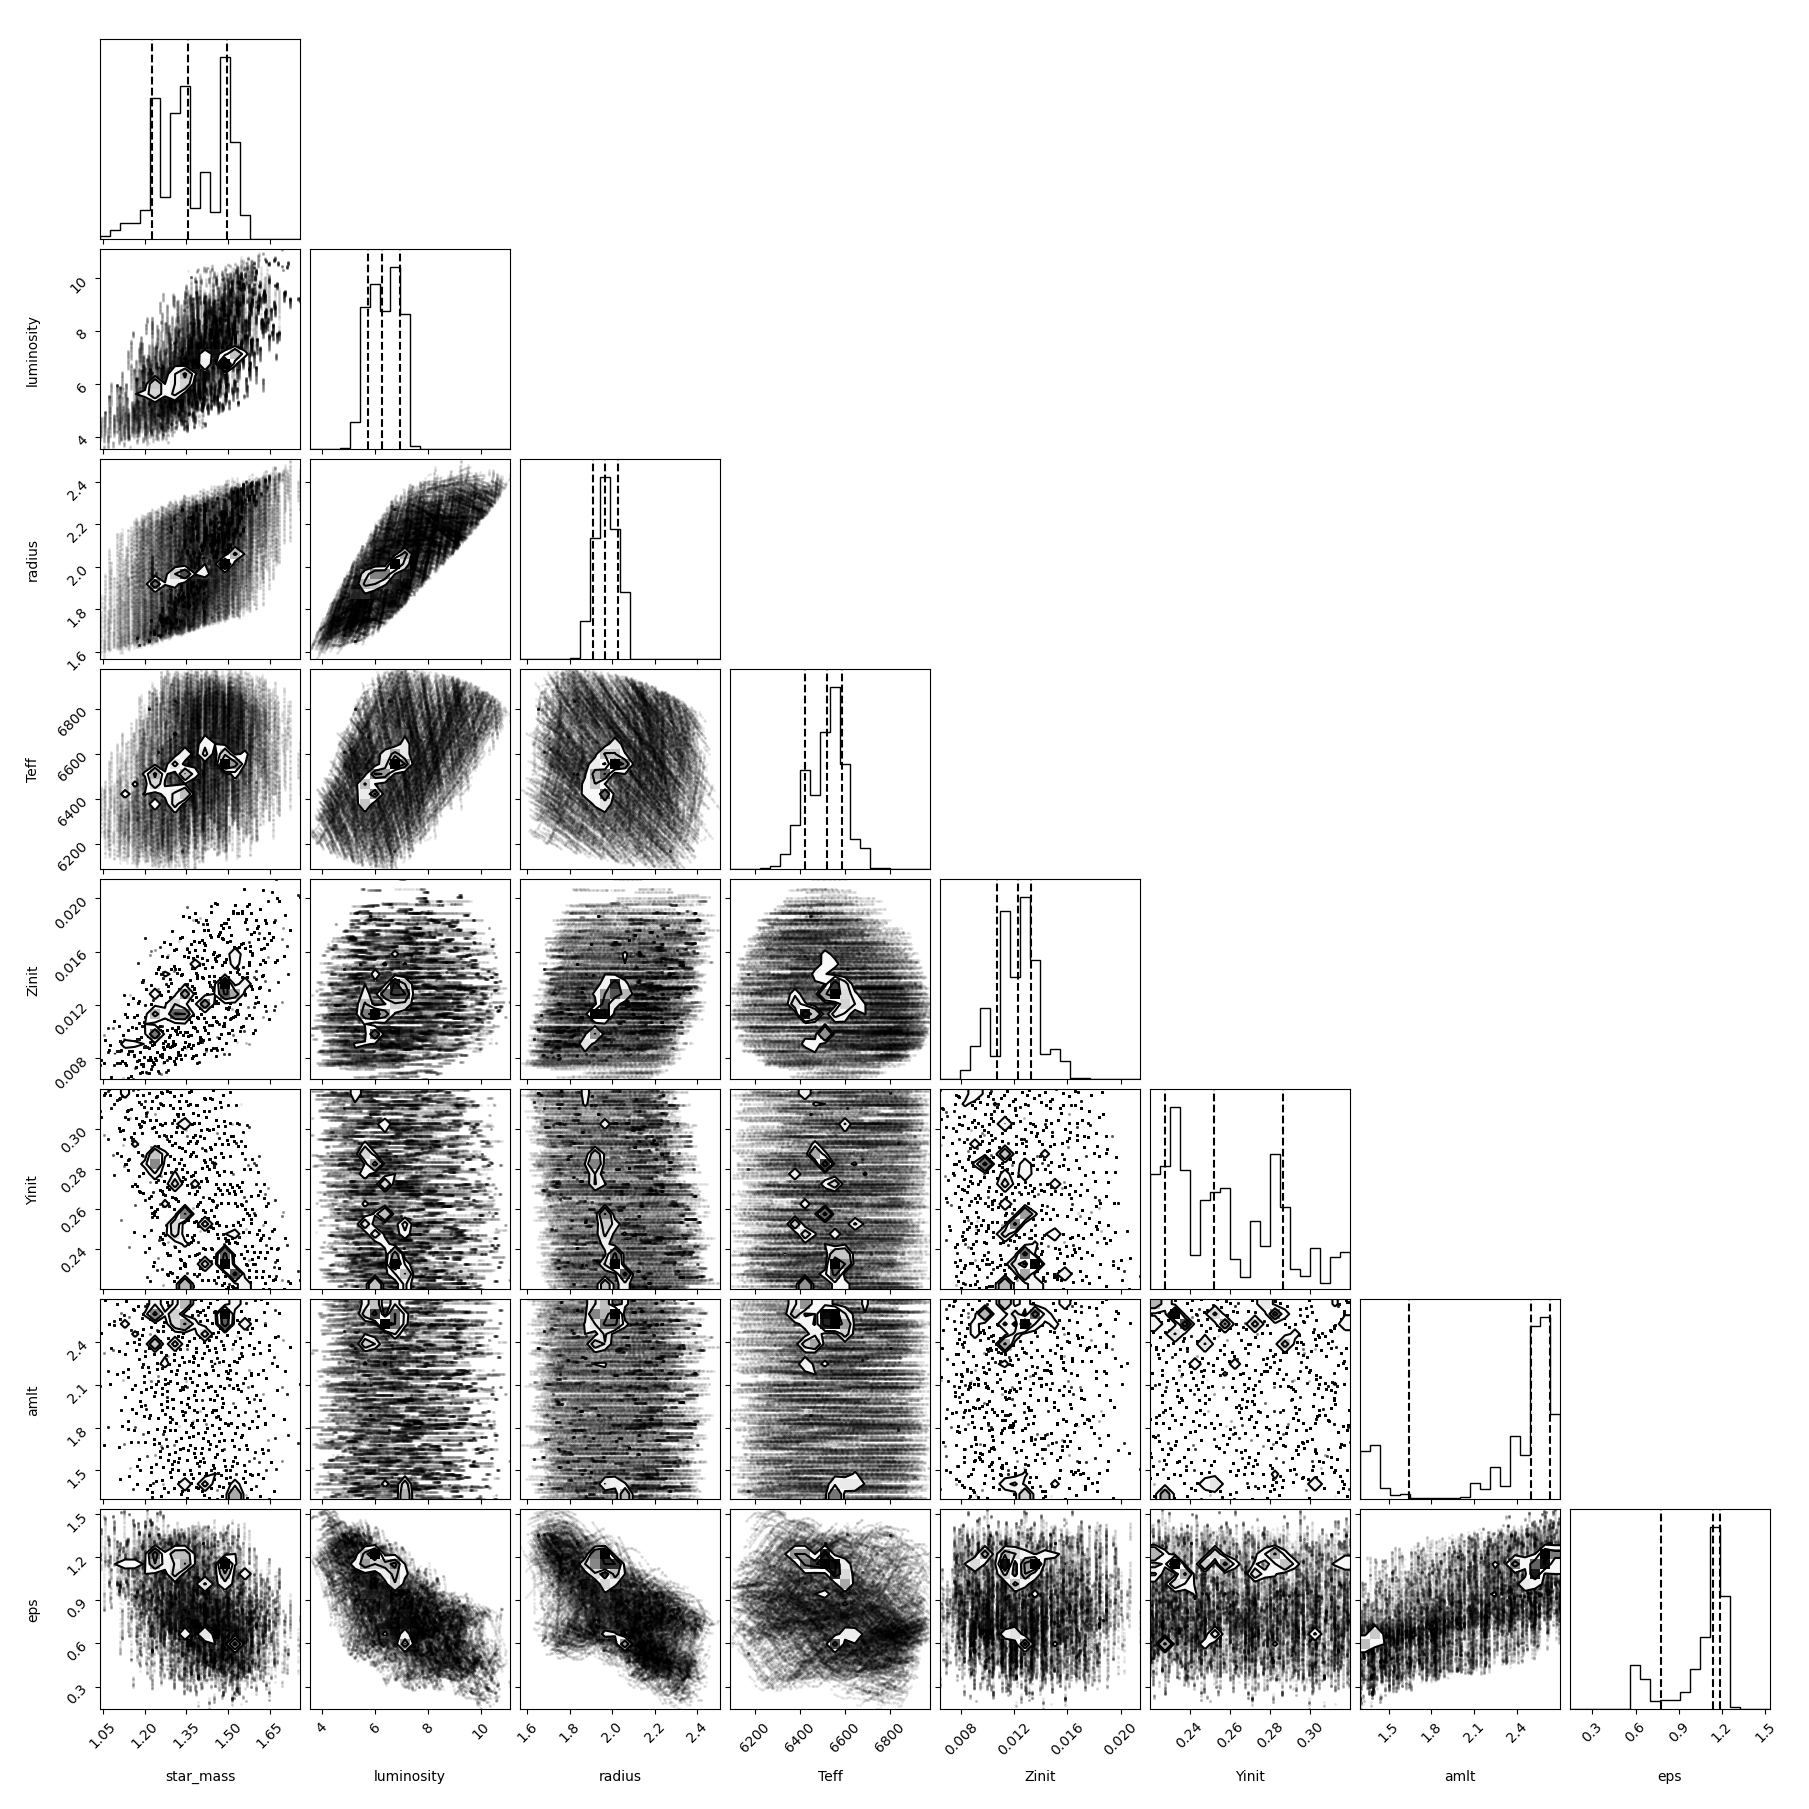

In [79]:
from IPython.display import Image
Image(filename='../hpc/results_sc_combined_linear_ind/{:0.0f}/corner_prob.png'.format(3)) 

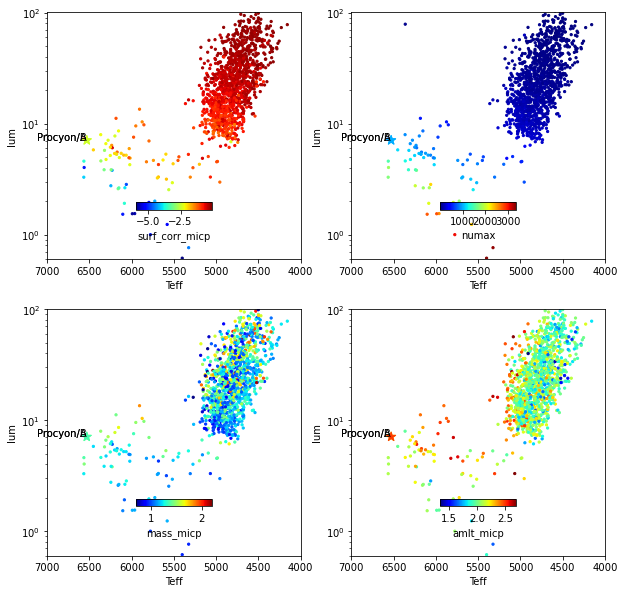

In [75]:
fig, axes = plt.subplots(figsize=[10,10], nrows=2, ncols=2, squeeze=False)
axes = axes.reshape(-1)

import matplotlib.colors

zvals = ['surf_corr_micp', 'numax', 'mass_micp', 'amlt_micp']
for iax in range(len(axes)):
    zval = zvals[iax]
    norm = matplotlib.colors.Normalize(vmin=sample[zval].min(), vmax=sample[zval].max())
    idx = ~np.isin(sample['names'], ['Procyon/A', 'Procyon/B'])
    
    c=axes[iax].scatter(sample.loc[idx,'Teff'], sample.loc[idx,'lum_J'], c=sample.loc[idx,zval], s=5, cmap='jet', norm=norm)
    axes[iax].scatter(sample.loc[~idx,'Teff'], sample.loc[~idx,'lum_J'], c=sample.loc[~idx,zval], marker='*', s=90, cmap='jet', norm=norm)
    axes[iax].set_xlim(7000, 4000)
    axes[iax].set_ylim(0.6, 100.8)
    axes[iax].set_yscale('log')
    axes[iax].set_xlabel('Teff')
    axes[iax].set_ylabel('lum')
    
    cax = axes[iax].inset_axes([0.35, 0.2, 0.3, 0.03], transform=axes[iax].transAxes)
    fig.colorbar(c, cax=cax, orientation='horizontal').set_label(zval)

    for istar, star in sample.loc[~idx,:].iterrows():
        axes[iax].text(sample.loc[istar,'Teff'], sample.loc[istar,'lum_J'], sample.loc[istar,'names'], ha='right')